# 1. Gender Classification Using Bidirectional Long short-term memory (BiLSTM)

## 1.1 Necessary libraries

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Dense, Activation, Dropout, LSTM, Bidirectional
from sklearn.model_selection import train_test_split
from tensorflow.keras.regularizers import l2

## 1.2 Download the dataset

In [2]:
import requests
url = "https://data.brasil.io/dataset/genero-nomes/nomes.csv.gz"
filename = url.split("/")[-1]
with open(filename, "wb") as f:
    r = requests.get(url)
    f.write(r.content)

df = pd.read_csv('nomes.csv.gz') 
df.head()

,alternative_names,classification,first_name,frequency_female,frequency_male,frequency_total,frequency_group,group_name,ratio
0,AILINE|ALEINE|ALIINE|ALINE|ALINER|ALINHE|ALINN...,F,AALINE,66.0,NaN,66,530550,ALINE,1.0
1,ARAAO|ARAO,M,AARAO,NaN,281.0,281,3526,ARAO,1.0
2,AHARON|AROM|ARON|ARYON|HARON,M,AARON,NaN,676.0,676,3442,ARON,1.0
3,ADA|ADAH|ADAR|ADHA|HADA,F,ABA,82.0,NaN,82,5583,ADA,1.0
4,NaN,M,ABADE,NaN,57.0,57,57,ABADE,1.0


### 1.2.1 Preparing the data 

In [3]:
y = df['classification'].astype("category").cat.codes.values # y labels into numbers
names = df['first_name'].apply(lambda x: x.lower()) # input names

## 1.3 Encoding Words

In [4]:
maxlen = 20
vocab = set(' '.join([str(i) for i in names]))
vocab.add('END')
len_vocab = len(vocab)
char_index = dict((c, i) for i, c in enumerate(vocab))

In [5]:
x = []
# Builds an empty line with a 1 at the index of character
def set_flag(i):
    tmp = np.zeros(len_vocab);
    tmp[i] = 1
    return list(tmp)

# Truncate names and create the matrix
def prepare_encod_names(X):
    new_list = []
    trunc_train_name = [str(i)[0:maxlen] for i in X]

    for i in trunc_train_name:
        tmp = [set_flag(char_index[j]) for j in str(i)]
        for k in range(0,maxlen - len(str(i))):
            tmp.append(set_flag(char_index["END"]))
        new_list.append(tmp)

    return new_list


x = prepare_encod_names(names.values)

## 1.4 Split the data into test and train

In [14]:
# train, val, test set will be 60%, 20%, 20% of the dataset respectively
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=1)

x_train = np.asarray(x_train)
y_train = np.asarray(y_train)
x_test = np.asarray(x_test)
y_test = np.asarray(y_test)
x_val = np.asarray(x_val)
y_val = np.asarray(y_val)

## 1.5 Building the BiLSTM Model

In [15]:
model = Sequential()
model.add(Bidirectional(LSTM(64, return_sequences=True), backward_layer=LSTM(64, return_sequences=True, go_backwards=True), input_shape=(maxlen,len_vocab)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.2))
model.add(Dense(1, activity_regularizer=l2(0.002)))
model.add(Activation('sigmoid'))

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

# print the model
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_4 (Bidirection (None, 20, 128)           47616     
_________________________________________________________________
dropout_4 (Dropout)          (None, 20, 128)           0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 128)               98816     
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total params: 146,561
Trainable params: 146,561
Non-trainable params: 0
________________________________________________

## 1.6 Fitting the data into model

In [16]:
history = model.fit(x_train, y_train, batch_size=128, epochs=5, validation_data =(x_val, y_val))
scores = model.evaluate(x_test, y_test) 
print("Accuracy: %.2f%%" % (scores[1]*100))

Epoch 1/5
473/473 [==============================] - 64s 120ms/step - loss: 0.3621 - accuracy: 0.8320 - val_loss: 0.2142 - val_accuracy: 0.9276
Epoch 2/5
473/473 [==============================] - 55s 117ms/step - loss: 0.2110 - accuracy: 0.9284 - val_loss: 0.1830 - val_accuracy: 0.9410
Epoch 3/5
473/473 [==============================] - 55s 117ms/step - loss: 0.1792 - accuracy: 0.9442 - val_loss: 0.1698 - val_accuracy: 0.9483
Epoch 4/5
473/473 [==============================] - 55s 117ms/step - loss: 0.1647 - accuracy: 0.9512 - val_loss: 0.1645 - val_accuracy: 0.9512
Epoch 5/5
630/630 [==============================] - 6s 10ms/step - loss: 0.1608 - accuracy: 0.9517
Accuracy: 95.17%


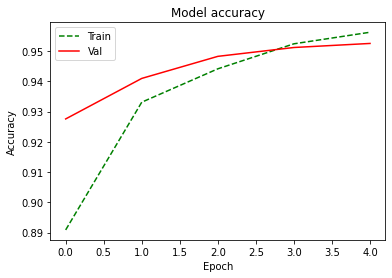

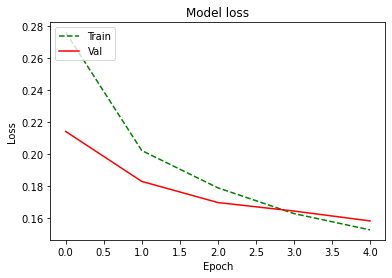

In [17]:
# summarize history for accuracy
plt.plot(history.history['accuracy'], 'g--')
plt.plot(history.history['val_accuracy'], 'r')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'], 'g--')
plt.plot(history.history['val_loss'], 'r')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

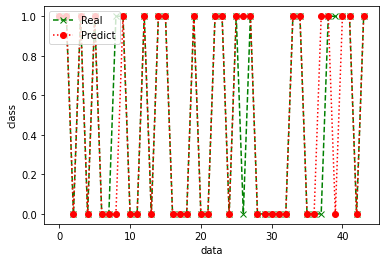

In [20]:
y_pred =(model.predict(x_test) > 0.5).astype("int32")
plt.figure(2)
plt.plot(y_test[6:50], 'g--x')
plt.plot(y_pred[6:50], 'r:o')
plt.ylabel('class')
plt.xlabel('data')
plt.legend(['Real', 'Predict'], loc='upper left')
plt.show()